## Problem Statements:
### To predict the Cocacola sales

### Import libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot

import statsmodels.formula.api as smf 

import warnings
warnings.filterwarnings("ignore")

### Reading the csv file

In [2]:
coca_cola=pd.read_excel("/content/CocaCola_Sales_Rawdata.xlsx")
coca_cola.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


### Checking for null values

In [3]:
coca_cola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


### Check in the statistics terms to get basic ideas

In [4]:
coca_cola.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


### Performing the basic visualization of the forecasting

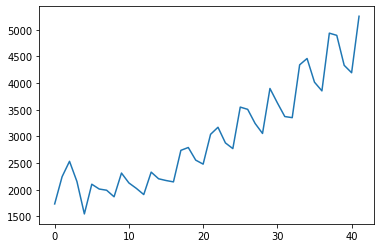

In [5]:
coca_cola.Sales.plot()

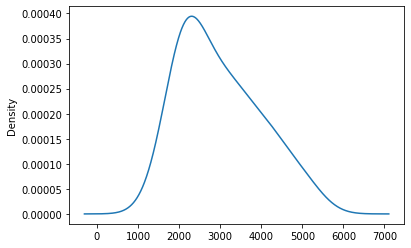

In [6]:
coca_cola.Sales.plot(kind='kde')

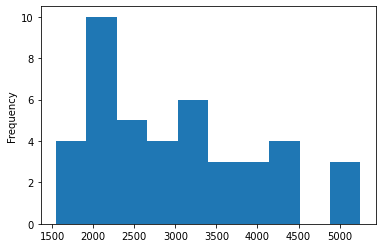

In [7]:
coca_cola.Sales.plot(kind='hist')

In [8]:
param=pd.read_excel('CocaCola_Sales_Rawdata.xlsx',header=0,index_col=0,parse_dates=True,squeeze=True)

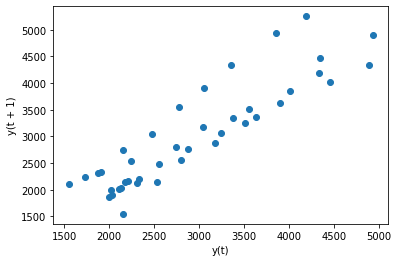

In [9]:
lag_plot(param)

### Seperating and Aggregating the Quarters and years present in the 'Quarter' column of the original data, in order to do one hot encoding.

In [10]:
coca_cola['Quarters']=0
coca_cola['Year']=0
for i in range(42):
    p=coca_cola['Quarter'][i]
    coca_cola['Quarters'][i]=p[0:2]
    coca_cola['Year'][i]=p[3:5]    
coca_cola.head()

,Quarter,Sales,Quarters,Year
0,Q1_86,1734.827000,Q1,86
1,Q2_86,2244.960999,Q2,86
2,Q3_86,2533.804993,Q3,86
3,Q4_86,2154.962997,Q4,86
4,Q1_87,1547.818996,Q1,87


In [11]:
quater_dumies=pd.DataFrame(pd.get_dummies(coca_cola['Quarters']))
quater_dumies.head()

,Q1,Q2,Q3,Q4
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1
4,1,0,0,0


### Concatinating the new dummy variables that are created for the Quarter column with the original dataset

In [12]:
coca_cola=pd.concat([coca_cola,quater_dumies],axis=1)

In [13]:
coca_cola.head()

,Quarter,Sales,Quarters,Year,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1,86,1,0,0,0
1,Q2_86,2244.960999,Q2,86,0,1,0,0
2,Q3_86,2533.804993,Q3,86,0,0,1,0
3,Q4_86,2154.962997,Q4,86,0,0,0,1
4,Q1_87,1547.818996,Q1,87,1,0,0,0


### Creating a time column for the dataset

In [14]:
coca_cola['time']=range(1,43)

### Creating a squared time column for the dataset, which will be used in the Quadratic model

In [15]:
coca_cola['time_sqr']=coca_cola['time']*coca_cola['time']

### Creating a log transformation of the target variable, to be used in the exponential model of forecasting

In [16]:
coca_cola['log_sales']=np.log(coca_cola['Sales'])

In [17]:
coca_cola.head()

,Quarter,Sales,Quarters,Year,Q1,Q2,Q3,Q4,time,time_sqr,log_sales
0,Q1_86,1734.827000,Q1,86,1,0,0,0,1,1,7.458663
1,Q2_86,2244.960999,Q2,86,0,1,0,0,2,4,7.716443
2,Q3_86,2533.804993,Q3,86,0,0,1,0,3,9,7.837477
3,Q4_86,2154.962997,Q4,86,0,0,0,1,4,16,7.675529
4,Q1_87,1547.818996,Q1,87,1,0,0,0,5,25,7.344602


### Heat map that shows the mean sales in each Quarter of the year

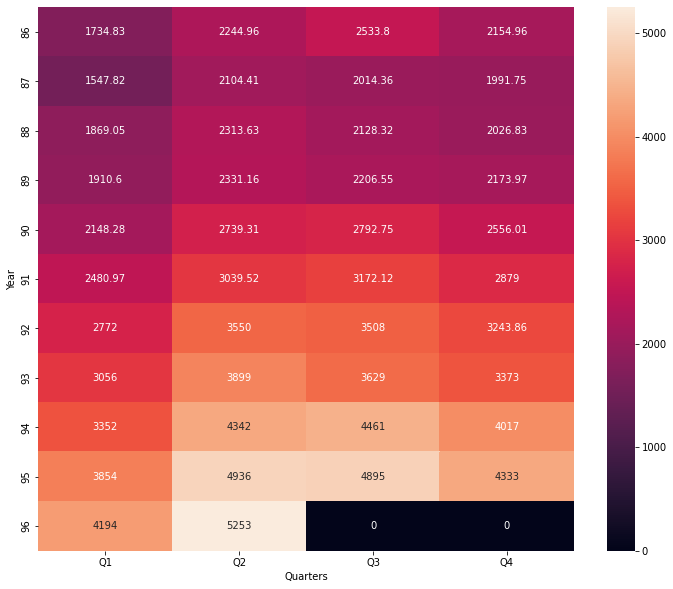

In [18]:
plt.figure(figsize=(12,10))
plot_month_y = pd.pivot_table(data =coca_cola,values="Sales",index="Year",columns="Quarters",aggfunc="mean",fill_value=0)
sns.heatmap(plot_month_y,annot=True,fmt = "g")

### A box plot to understand the sales of all the four quarters

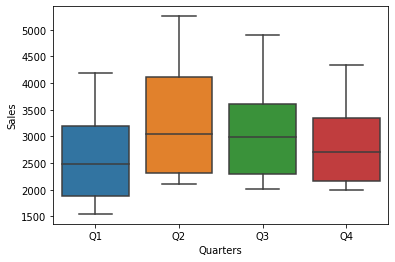

In [19]:
sns.boxplot(x='Quarters',y='Sales',data=coca_cola)

### A box plot to visualize the sales of coca cola throughout the years with 4 components - Trend, Cyclic,Seasonality and Irregularity component

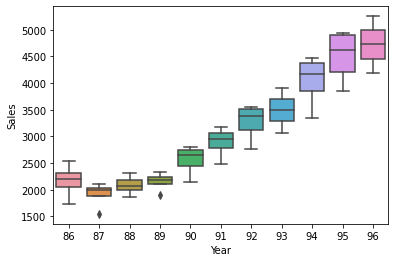

In [20]:
sns.boxplot(x='Year',y='Sales',data=coca_cola)

### Line plot to understand the past sales growth and to forecast the predictions

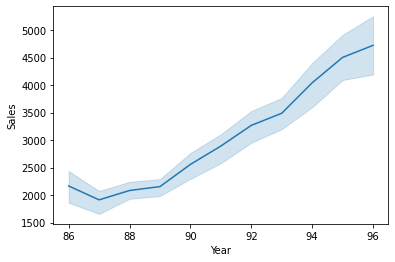

In [21]:
sns.lineplot(x='Year',y='Sales',data=coca_cola)

## Performing the Model driven methods of forecasting

### Splitting the data into train and test, in order to find the least RMSE model 

In [22]:
train=coca_cola.head(30)
test=coca_cola.tail(12)

### Developing a linear model

In [23]:
linear_model = smf.ols('Sales~time',data=coca_cola).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test['time'])))
rmse_linear = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_linear))**2))
rmse_linear

449.799622612296

### Developing an exponential model

In [24]:
Exp = smf.ols('log_sales~time',data=coca_cola).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test['time'])))
rmse_Exp = np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

417.5608283749833

### Developing a quadratic model


In [25]:
Quad = smf.ols('Sales~time+time_sqr',data=coca_cola).fit()
pred_Quad = pd.Series(Quad.predict(test[["time","time_sqr"]]))
rmse_Quad = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_Quad))**2))
rmse_Quad

394.7556159270099

### Developing an additive seasonality model

In [26]:
add_sea = smf.ols('Sales~Q1+Q2+Q3+Q4',data=coca_cola).fit()
pred_add_sea = pd.Series(add_sea.predict(test[['Q1','Q2','Q3','Q4']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1305.6638874921077

### Developing an additive seasonality quadratic model

In [27]:
add_sea_Quad = smf.ols('Sales~time+time_sqr+Q1+Q2+Q3+Q4',data=coca_cola).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test[['time','time_sqr','Q1','Q2','Q3','Q4']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

170.42727210325964

### Developing a multiplicative seasonality model

In [28]:
Mul_sea = smf.ols('log_sales~Q1+Q2+Q3+Q4',data = coca_cola).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

1435.5011310008917

### Developing a multiplicative additive seasonality model

In [29]:
Mul_Add_sea = smf.ols('log_sales~time+Q1+Q2+Q3+Q4',data = coca_cola).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

172.15056883930296

### Compare the results 

In [30]:
data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),
        "RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
4,rmse_add_sea_quad,170.427272
6,rmse_Mult_add_sea,172.150569
2,rmse_Quad,394.755616
1,rmse_Exp,417.560828
0,rmse_linear,449.799623
3,rmse_add_sea,1305.663887
5,rmse_Mult_sea,1435.501131


### Predict using the additive seasonaility quadratic model on the whole data

In [31]:
model_full = smf.ols('Sales~time+time_sqr+Q1+Q2+Q3+Q4',data = coca_cola).fit()
pred_full = pd.Series(model_full.predict(coca_cola))


In [32]:
coca_cola["Predicted_sales"]=pred_full
coca_cola.head()

,Quarter,Sales,Quarters,Year,Q1,Q2,Q3,Q4,time,time_sqr,log_sales,Predicted_sales
0,Q1_86,1734.827000,Q1,86,1,0,0,0,1,1,7.458663,1626.592727
1,Q2_86,2244.960999,Q2,86,0,1,0,0,2,4,7.716443,2268.402339
2,Q3_86,2533.804993,Q3,86,0,0,1,0,3,9,7.837477,2189.685821
3,Q4_86,2154.962997,Q4,86,0,0,0,1,4,16,7.675529,1867.242917
4,Q1_87,1547.818996,Q1,87,1,0,0,0,5,25,7.344602,1658.311143


## Conclusion:
### From all the models listed above, we are getting the lowest RMSE value in additive seasonality quadratic model of 170.42, and thus we build a model to predict using the same model on the whole data.